In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.seasonal import seasonal_decompose

plt.style.use('dark_background')

data_path = 'Data/co2_mm_gl.csv'
df = pd.read_csv(data_path, comment='#')

print(df.head())

   year  month   decimal  average  average_unc   trend  trend_unc
0  1979      1  1979.042   336.56         0.11  335.92       0.09
1  1979      2  1979.125   337.29         0.09  336.25       0.09
2  1979      3  1979.208   337.88         0.11  336.51       0.09
3  1979      4  1979.292   338.32         0.13  336.72       0.10
4  1979      5  1979.375   338.26         0.04  336.71       0.10


In [15]:
date_components = {
    'year': df['year'],
    'month': df['month'],
    'day': 1  # since data is monthly, we set day to 1
}
df['date'] = pd.to_datetime(date_components)

df.set_index('date', inplace=True)

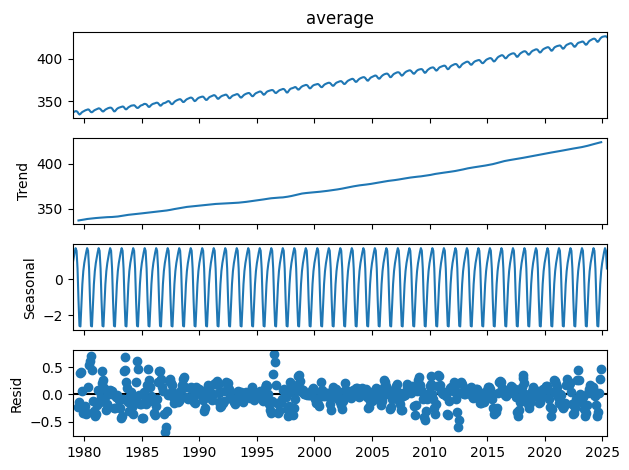

In [19]:
co2_series = df['average'].dropna()
co2_series_decomposed = seasonal_decompose(co2_series, model='additive', period=12)
fig = co2_series_decomposed.plot()
plt.savefig('Plots/co2_decomposition_raw_output.png')
plt.show()

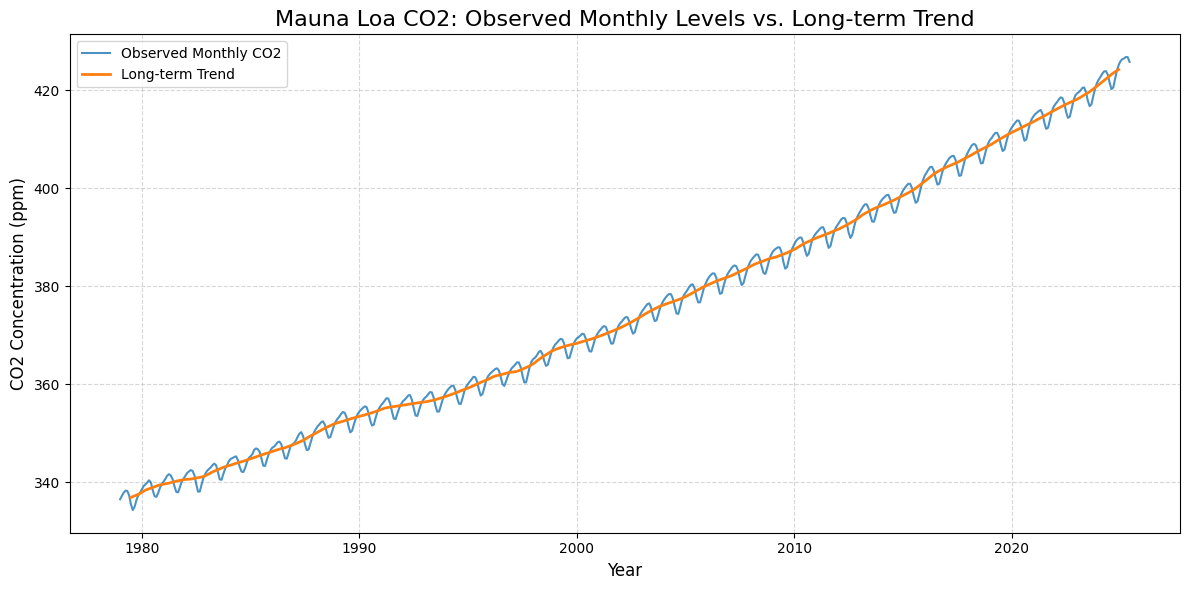

In [17]:
# Raw data + Trend
fig, ax = plt.subplots(figsize=(12,6))
# plot raw data
ax.plot(co2_series.index, co2_series, label='Observed Monthly CO2', color='#1f77b4', alpha=0.8)
# plot trend component
ax.plot(co2_series_decomposed.trend.index, co2_series_decomposed.trend, label='Long-term Trend', color='#ff7f0e', linewidth=2)
# add title and labels
ax.set_title('Mauna Loa CO2: Observed Monthly Levels vs. Long-term Trend', fontsize=16)
ax.set_xlabel('Year', fontsize=12)
ax.set_ylabel('CO2 Concentration (ppm)', fontsize=12)
# add legend
ax.legend(fontsize=10)
# add grid for readability
ax.grid(True, linestyle='--', alpha=0.5)

plt.tight_layout()
plt.savefig('Plots/co2_observed_and_trend.png', dpi=300, bbox_inches='tight')
plt.show()



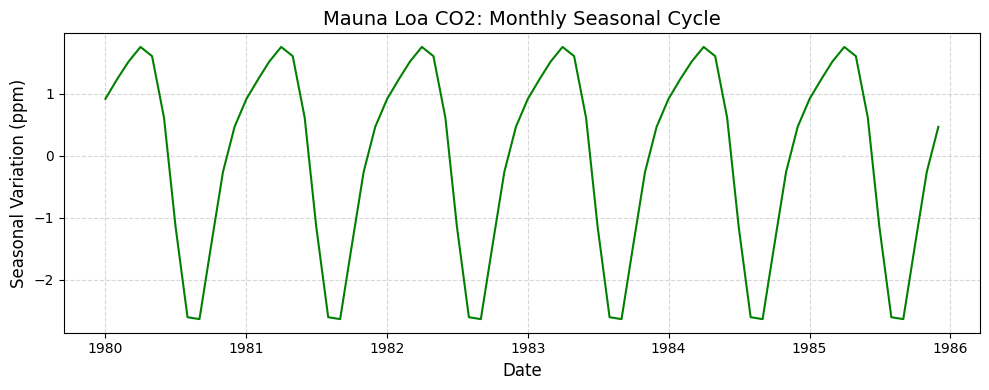

In [18]:
fig, ax = plt.subplots(figsize=(10,4))
# plot seasonal component
ax.plot(co2_series_decomposed.seasonal.loc['1980':'1985'].index, 
        co2_series_decomposed.seasonal.loc['1980':'1985'], 
        color='green', linewidth=1.5)
# add title and labels
ax.set_title('Mauna Loa CO2: Monthly Seasonal Cycle', fontsize=14)
ax.set_xlabel('Date', fontsize=12)
ax.set_ylabel('Seasonal Variation (ppm)', fontsize=12)
# add grid for readability
ax.grid(True, linestyle='--', alpha=0.5)

plt.tight_layout()
plt.savefig('Plots/co2_seasonal_cycle.png', dpi=300, bbox_inches='tight')
plt.show()